# Western United States UCLA Daily Snow Reanalysis, Version 1

**Goal: Dataset pre-processing for efficient spatiotemporal analysis with Xarray**


DATA SET ID: WUS_UCLA_SR (DOI: 10.5067/PP7T2GBI52I2)

https://nsidc.org/data/wus_ucla_sr/versions/1#anchor-2

This Western United States snow reanalysis data set contains daily estimates of posterior snow water equivalent (SWE), fractional snow-covered area (fSCA) and snow depth (SD) at 16 arc-second (~500 m) resolution from water years 1985 to 2021

Quick Facts:

* Parameter(s): SNOW DEPTH, SNOW WATER EQUIVALENT 
* Platform(s): LANDSAT-5, LANDSAT-7, LANDSAT-8
* Sensor(s): ETM+, OLI, TM
* Data Format(s): netCDF-4 classic, PNG
* Temporal Coverage: 1 October 1984 to 30 September 2021
* Temporal Resolution: 1 day
* Spatial Resolution: 0.004444 degrees 0.004444 degrees
* Spatial Reference System(s): WGS 84 EPSG:4326
* Spatial Coverage: N: 49 S: 31 E: -102 W: -125

In [5]:
#%pip install --upgrade earthaccess
%load_ext watermark

In [6]:
import xarray as xr
import pandas as pd
import fsspec
import earthaccess
import folium
import os
import dask
%config InlineBackend.figure_format='retina'
%watermark --iversions

xarray     : 2022.11.0
sys        : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
dask       : 2022.10.2
fsspec     : 2023.10.0
folium     : 0.13.0
earthaccess: 0.7.1
pandas     : 1.5.1



In [7]:
# Work on SSD Scratch Drive
os.chdir('/tmp')

## Step 1: Find data for a given area of interest

In User Guide PDF from NSIDC website we see data granules on 1x1 degree grids labelled by SW Corner so
WUS_UCLA_SR_v01_N48_0W124_0_agg_16_WY2019_20_SWE_SCA_POST.nc -> (-124, 48)

We're interested in Mt. Rainier, Washington State, USA

### Plot the 1x1deg box covering a point of interest

In [15]:
# Skagit
lat = 48.6
lon = -121.4

m = folium.Map(
    location=[lat, lon],
    zoom_start=8,
)

def get_rectangle(S,W):
    upper_left=(S+1,W)
    upper_right=(S+1,W+1)
    lower_right=(S,W+1)
    lower_left=(S,W)
    edges = [upper_left, upper_right, lower_right, lower_left]
    return edges

west, south = (-121.4, 46.6)

folium.Rectangle(bounds=get_rectangle(south, west), color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(m)
m

### NASA earthaccess search

In [16]:
%%time 
results = earthaccess.search_data(
    doi="10.5067/PP7T2GBI52I2",
    point=(lon,lat),
    #bounding_box=(west, south, west+1, south+1),
    #temporal=("2020-02", "2023-03"),
)

Granules found: 74
CPU times: user 96.3 ms, sys: 36.5 ms, total: 133 ms
Wall time: 1.81 s


In [18]:
first = results[0]
first

Collection: {'EntryTitle': 'Western United States UCLA Daily Snow Reanalysis V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -121.998, 'EastBoundingCoordinate': -121.001, 'NorthBoundingCoordinate': 48.9978, 'SouthBoundingCoordinate': 48.0023}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '1984-10-01T00:00:00.000Z', 'EndingDateTime': '1985-09-30T23:59:59.000Z'}}
Size(MB): 287.34
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1984.10.01/WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc']

In [26]:
# NOTE: 'SD' = Snow Depth, 'SWE' = Snow Water Equivalent
links = [g.data_links()[0] for g in results]
subset = [x for x in links if 'SWE' in x]
subset[:3]

['https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1984.10.01/WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc',
 'https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1985.10.01/WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1985_86_SWE_SCA_POST.nc',
 'https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1986.10.01/WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1986_87_SWE_SCA_POST.nc']

## Step 2: Inspect a single scene

In [27]:
!time wget -nc {subset[0]}

zsh:1: command not found: wget
wget -nc   0.00s user 0.00s system 60% cpu 0.001 total


In [28]:
!ls -lh WUS_UCLA*.nc

zsh:1: no matches found: WUS_UCLA*.nc


In [29]:
files = [x.split('/')[-1] for x in subset]
years = [x.split('/')[-2][:4] for x in subset]

In [30]:
i = 0
path = files[i]
year = years[i]
print(path)

WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc


In [31]:
# Water year timestamps
timestamps = pd.date_range(start=f'{year}-10-01', end=f'{int(year)+1}-09-30')

In [34]:
# Load data & re-format for analysis
ds = xr.open_dataset(path)

# Promote non-dimensional coordinates to dimensions
ds = ds.assign_coords(dict(Day=timestamps, 
                           Stats=['mean','std','median','25%','75%'], # From documentation 
                          ))

ds

FileNotFoundError: [Errno 2] No such file or directory: b'/private/tmp/WUS_UCLA_SR_v01_N48_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc'

In [33]:
# NOTE size of entire dataset (MB uncompressed in memory)
ds.nbytes/1e6

NameError: name 'ds' is not defined

In [15]:
# Check on-disk chunking of data
# NOTE: compressed and chunked by day-of-year
ds.SWE_Post.encoding

{'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 9,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 5, 225, 225),
 'preferred_chunks': {'Day': 1, 'Stats': 5, 'Longitude': 225, 'Latitude': 225},
 'source': '/tmp/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc',
 'original_shape': (365, 5, 225, 225),
 'dtype': dtype('float32'),
 '_FillValue': -999.0}

In [16]:
ds.SWE_Post.dims

('Day', 'Stats', 'Longitude', 'Latitude')

In [17]:
# Switch order of lon & lat for plots to display correctly,
# or use https://cf-xarray.readthedocs.io/en/latest/! 
ds = ds.transpose()
ds.SWE_Post.dims

('Latitude', 'Longitude', 'Stats', 'Day')

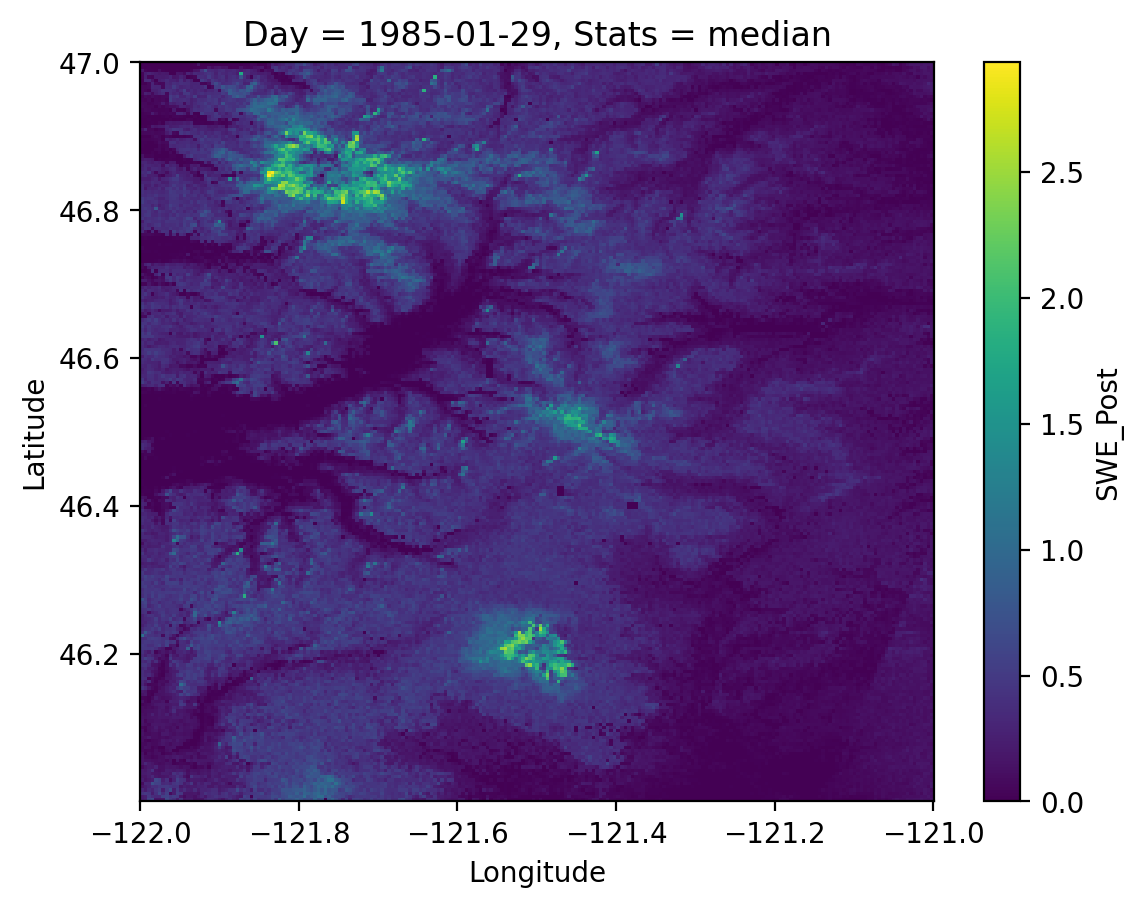

In [18]:
# Make a plot
ds.SWE_Post.sel(Stats='median').isel(Day=120).plot();

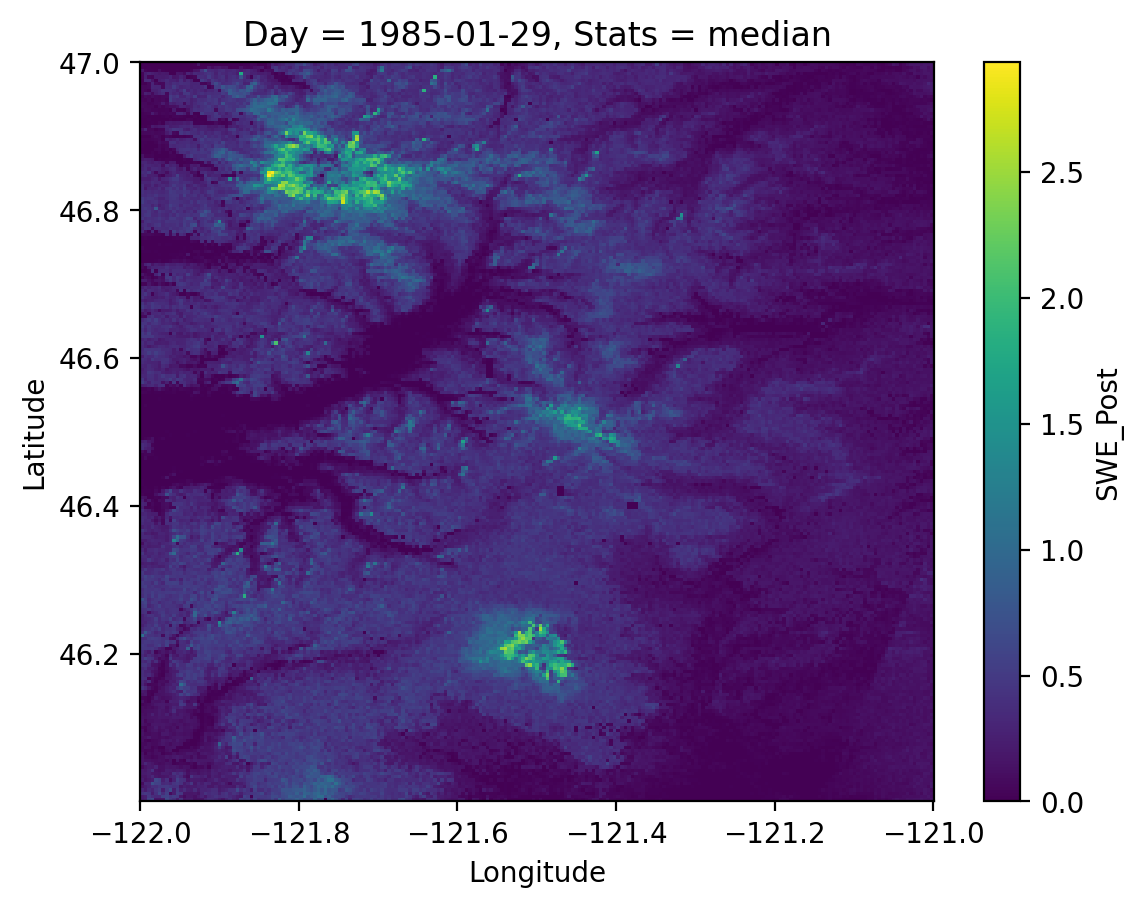

In [19]:
# Or select by day label
ds.SWE_Post.sel(Stats='median', Day='1985/01/29').plot();

In [20]:
# Plot monthly means in image grid
monthly = ds.SWE_Post.sel(Stats='median').resample(Day='1 m').mean()

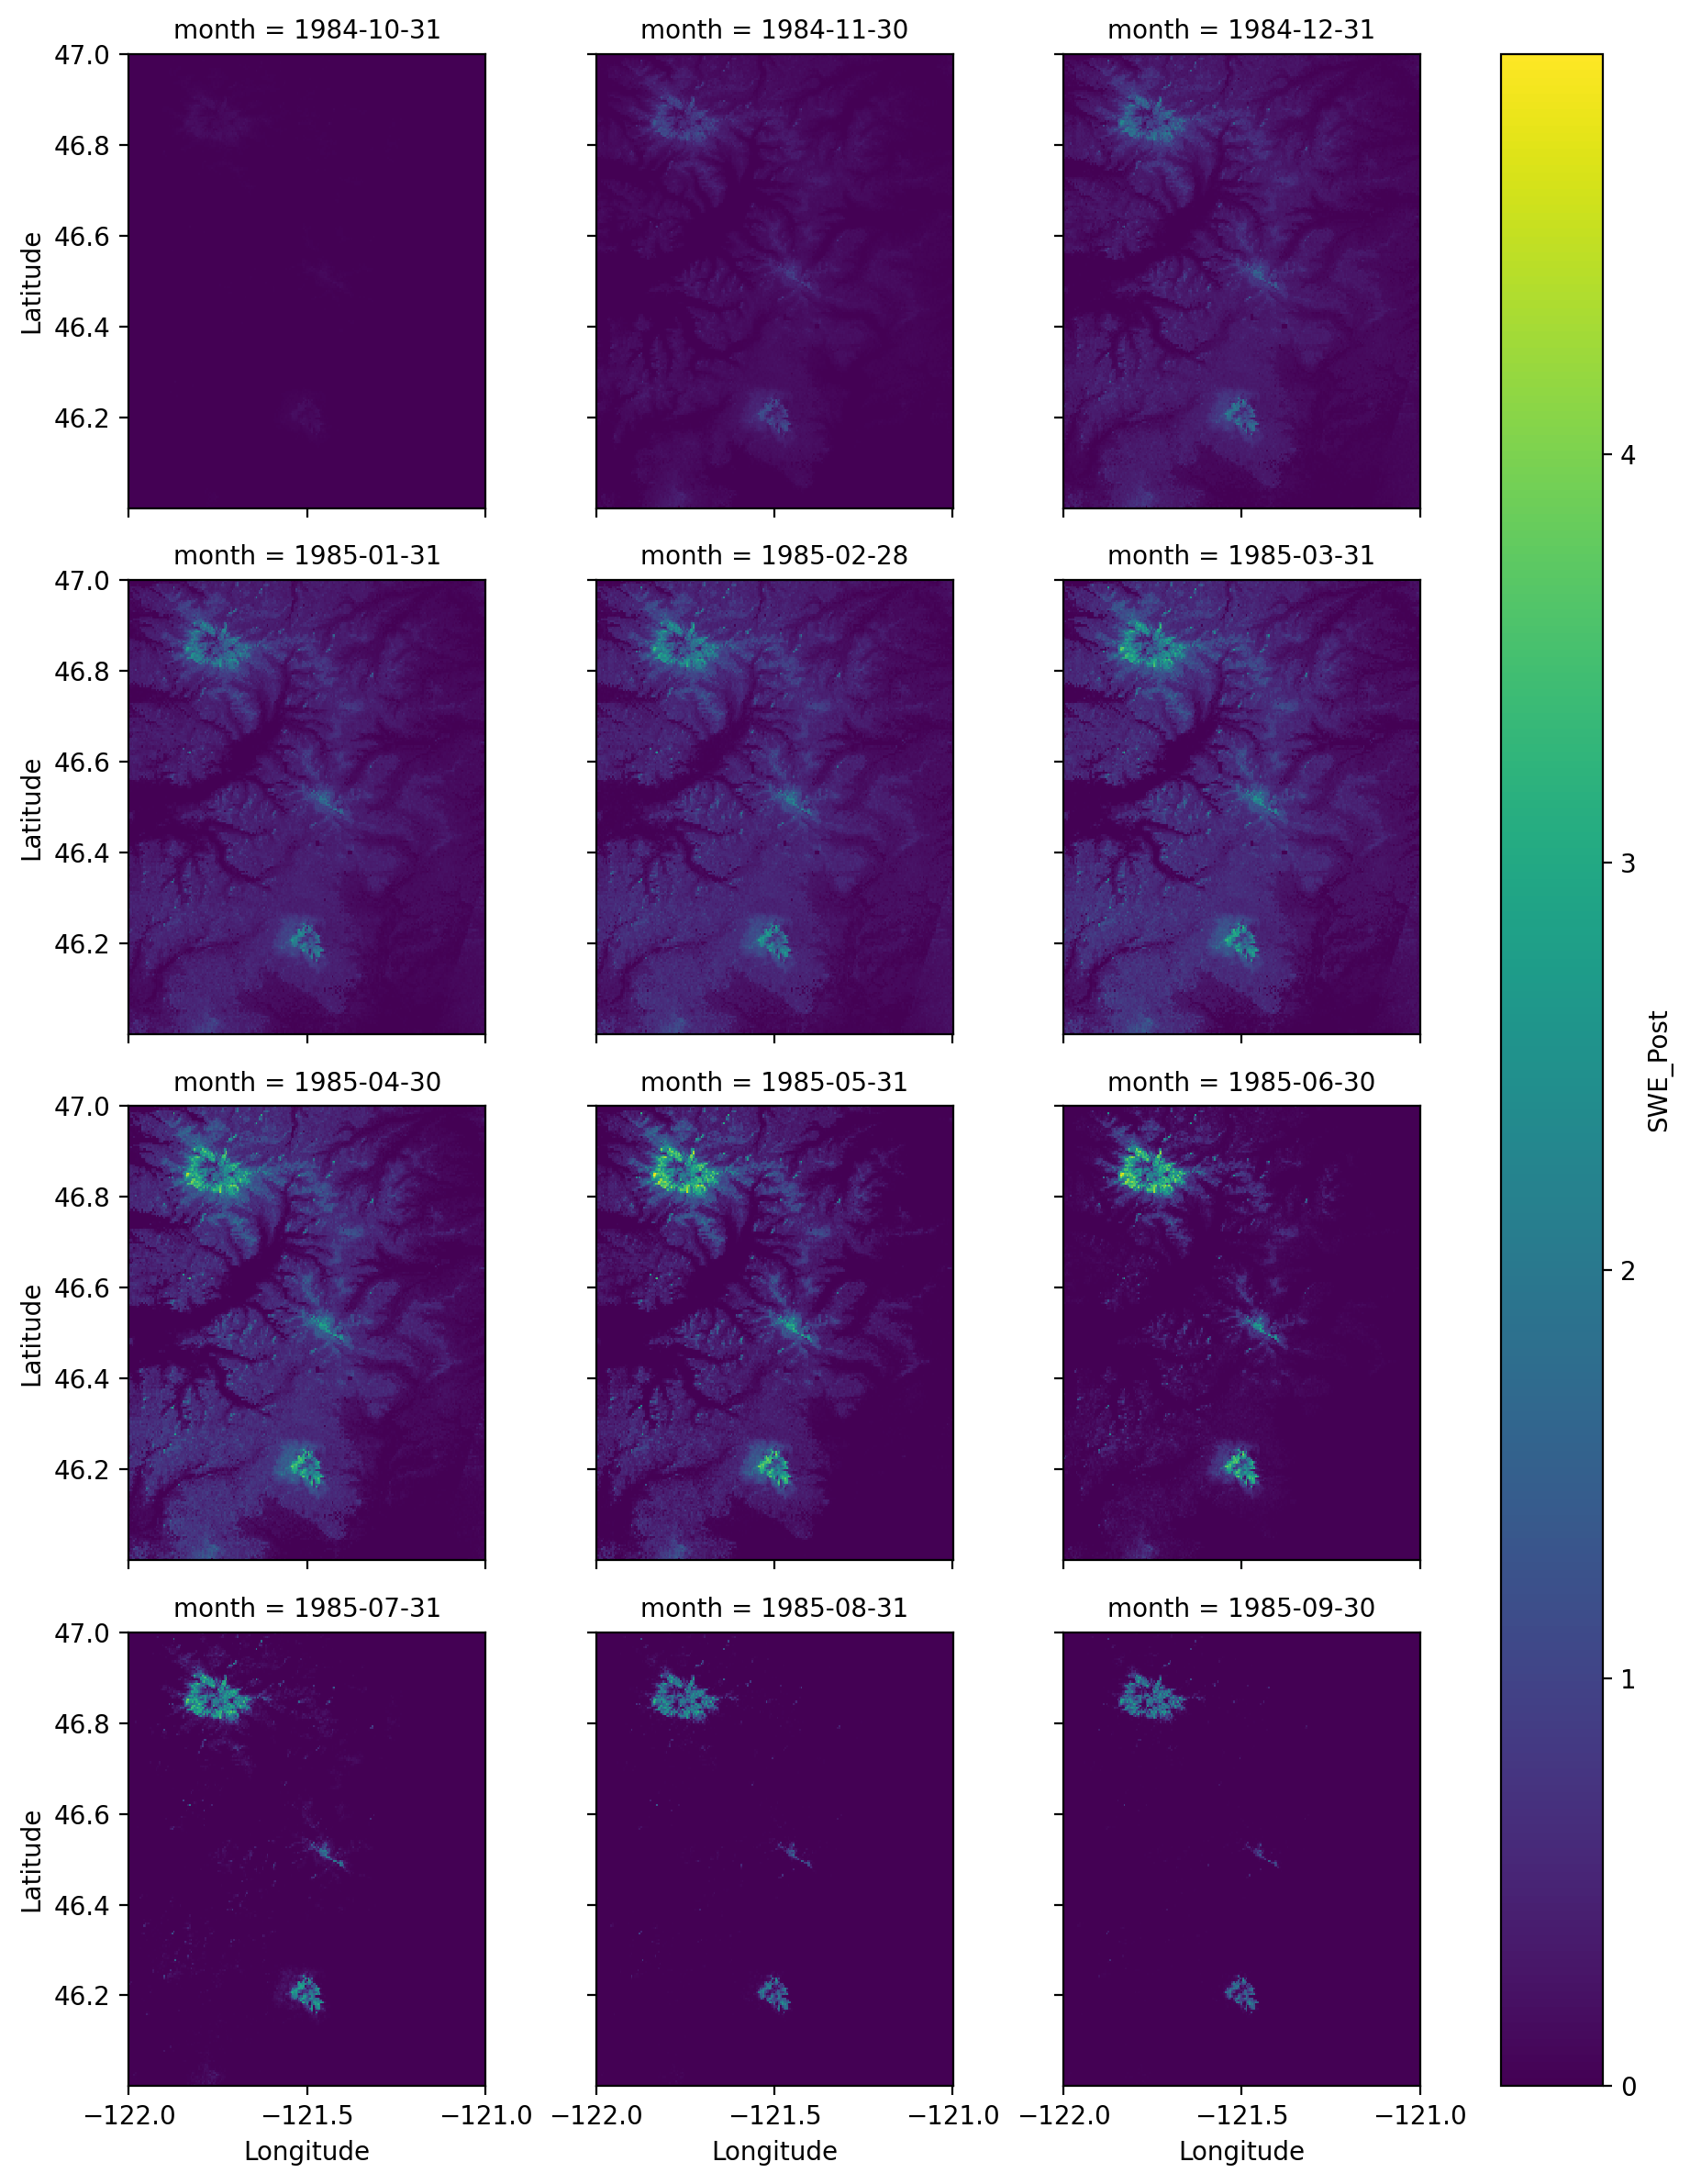

In [21]:
monthly.rename({'Day':'month'}).plot(col='month', col_wrap=3)

## Stack of images over time

In [22]:
# Work with just 3 years for starters
files = subset[:3]
files

['https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1984.10.01/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc',
 'https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1985.10.01/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1985_86_SWE_SCA_POST.nc',
 'https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/1986.10.01/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1986_87_SWE_SCA_POST.nc']

In [23]:
# Handles NASA Earthdata Loging
fs = earthaccess.get_fsspec_https_session()

In [24]:
%%time

# Pre-download all the files you want to work with, will re-use cache until /tmp is cleared
@dask.delayed
def lazy_open(url):
    return fsspec.open('filecache::'+url,
                       https=dict(client_kwargs=fs.client_kwargs),
                       same_names=True,
                       filecache={'cache_storage':'/tmp/files'}).open()

# Uses multiple threads if availble
file_likes = dask.compute(*[lazy_open(url) for url in files])

CPU times: user 9.16 ms, sys: 292 µs, total: 9.45 ms
Wall time: 8.22 ms


In [25]:
file_likes

(<_io.BufferedReader name='/tmp/files/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1984_85_SWE_SCA_POST.nc'>,
 <_io.BufferedReader name='/tmp/files/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1985_86_SWE_SCA_POST.nc'>,
 <_io.BufferedReader name='/tmp/files/WUS_UCLA_SR_v01_N46_0W122_0_agg_16_WY1986_87_SWE_SCA_POST.nc'>)

In [26]:
# We must specific dimensions and add full timestamps to combine data along time dimension
# into one big datacube

def preprocessor(ds):
    ''' Assign full timestamps to concatenate over time '''
    
    #path = ds.encoding["source"] # NOT available for file-like objects
    # Hack solution
    file_name = ds.SWE_Post.encoding['source'].split('/')[-1].strip("'>")
    year = file_name.split('_')[-5].strip('WY')

    timestamps = pd.date_range(start=f'{year}-10-01', end=f'{int(year)+1}-09-30')
    
    # Use lowercase dimension names, change 'Day' to 'time'
    ds = ds.rename(dict(Longitude='x', Latitude='y', Day='time', Stats='stats'))
    
    # Promote non-dimensional coordinates to dimensions
    ds = ds.assign_coords(dict(time=timestamps, 
                               stats=['mean','std','median','25%','75%'], # Order known from datast documentation 
                              ))

    return ds


In [27]:
%%time 

DS = xr.open_mfdataset(file_likes, 
                       engine='h5netcdf',
                       preprocess=preprocessor
                      )

CPU times: user 113 ms, sys: 8.15 ms, total: 121 ms
Wall time: 121 ms


In [28]:
DS

<xarray.Dataset>
Dimensions:   (y: 225, x: 225, time: 1095, stats: 5)
Coordinates:
  * y         (y) float32 47.0 46.99 46.99 46.98 ... 46.02 46.01 46.01 46.0
  * x         (x) float32 -122.0 -122.0 -122.0 -122.0 ... -121.0 -121.0 -121.0
  * time      (time) datetime64[ns] 1984-10-01 1984-10-02 ... 1987-09-30
  * stats     (stats) <U6 'mean' 'std' 'median' '25%' '75%'
Data variables:
    SWE_Post  (time, stats, x, y) float32 dask.array<chunksize=(1, 5, 225, 225), meta=np.ndarray>
    SCA_Post  (time, stats, x, y) float32 dask.array<chunksize=(1, 5, 225, 225), meta=np.ndarray>

In [29]:
%%time
# Now plot continuous timeseries
# Mt. Rainier Snotel (-121.7476, 46.7826)
ts = DS.SWE_Post.sel(x=-121.7476, y=46.7826, method='nearest').sel(stats='mean').compute()

CPU times: user 8.79 s, sys: 273 ms, total: 9.07 s
Wall time: 8.82 s


In [30]:
ts

<xarray.DataArray 'SWE_Post' (time: 1095)>
array([0.    , 0.    , 0.    , ..., 0.0012, 0.0012, 0.0018], dtype=float32)
Coordinates:
    y        float32 46.78
    x        float32 -121.7
  * time     (time) datetime64[ns] 1984-10-01 1984-10-02 ... 1987-09-30
    stats    <U6 'mean'
Attributes:
    Units:    meters

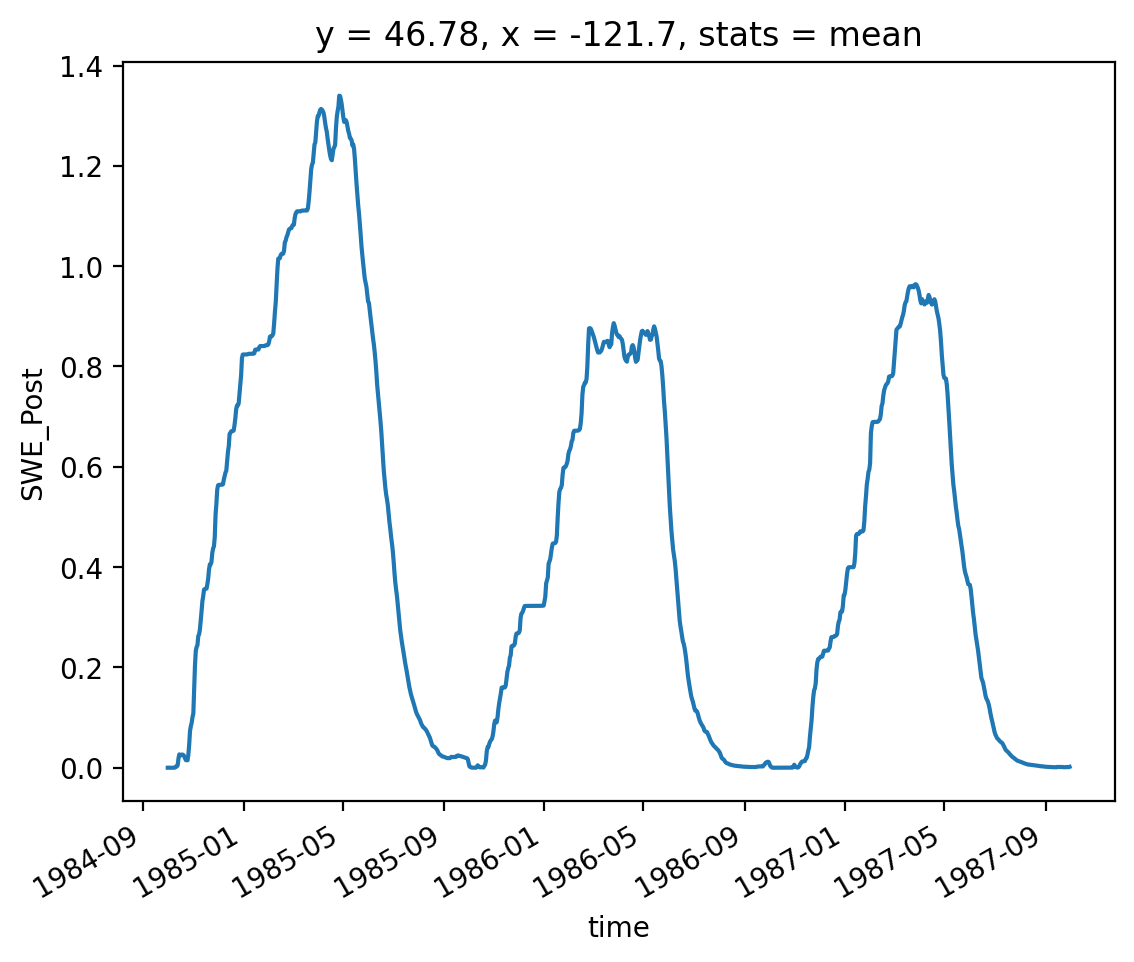

In [31]:
ts.plot();

In [32]:
# Next steps:
# Consider using kerchunk to create a reference Zarr dataset rather than pre-downloading